In [1]:
import numpy as np
import pandas as pd
import os
import re
import tqdm
import multiprocessing as mp
import sys
sys.path.append(os.path.realpath("../src"))
sys.path.append("/home/jbirky/Tresorit/packages/SALib/src")
import SALib
print(SALib.__file__)

import vplanet_inference as vpi
import tidal

import seaborn as sn
import astropy.units as u
import corner
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=25)
rc('ytick', labelsize=25)

/home/jbirky/Tresorit/packages/SALib/src/SALib/__init__.py


In [2]:
def get_table_s1(config_id, results_dir="../analysis/results_sensitivity"):
    
    synth = tidal.SyntheticModel(f"../analysis/config/config_{config_id}.yaml", verbose=False, compute_true=True)
    samp = np.load(f"{results_dir}/config_{config_id}/var_global_sensitivity_sample.npz")
    Y = samp["Y"]
    # Y[samp["Y"] > 50] = np.nan

    porb_prot = (Y.T[-2] / Y.T[-1]).T
    synth.variance_global_sensitivity(param_values=samp['param_values'], Y=np.vstack(porb_prot))
    # synth.variance_global_sensitivity(param_values=samp['param_values'], Y=Y)
    print(len(samp['Y']), "samples")
    
    age = synth.inparams_all.dict_true['vpl.dStopTime']
    
    return age, synth.table_s1


def get_tables_sorted(config_id_list, **kwargs):
    
    ages = []
    tables = []
    for cid in config_id_list:
        age, tab = get_table_s1(cid, **kwargs)
        ages.append(age)
        tables.append(tab)
        
    synth = tidal.SyntheticModel(f"../analysis/config/config_{config_id_list[0]}.yaml", verbose=False, compute_true=True)
    tsort = {"porb_prot": {}}

    for ii, tab in enumerate(tables):
        tsort["porb_prot"][str(int(ages[ii]))] = tab["porb_prot"]
        
    inlabels = synth.inparams_var.labels
    outlabels = ["porb_prot"]
    
    return tsort, inlabels, outlabels


def plot_tables_sorted(tsort, inlabels, outlabels, model="", save=False, show=True, cmap="bone",
                       xlabel=True, figsize=[22,8], title_size=35, annot_size=25,
                       savedir="../draft/figures", label_size=22, tkeys=None):
    
    if tkeys is None:
        tkeys = tsort.keys()
        
    fig, axs = plt.subplots(1, len(tkeys), figsize=figsize, sharey=True, dpi=400)
    plt.subplots_adjust(wspace=.01)
    
    for ii, key in enumerate(tkeys):
        df = pd.DataFrame(data=tsort[key])
        
        sn.heatmap(df, yticklabels=inlabels, annot=True, annot_kws={"size": 16}, vmin=0, vmax=1, cmap=cmap)
        plt.title(outlabels[ii] + " sensitivity", fontsize=label_size)
        plt.yticks(rotation=0)
        
        if xlabel == True:
            plt.xlabel("Age [Myr]", fontsize=label_size)
        plt.ylabel("Initial Conditions", fontsize=label_size)
        axs[0].set_ylabel(model.upper()[0:3] + "  initial conditions", fontsize=title_size)
        axs[0].tick_params(labelrotation=0)
        
        if save == True:
            plt.savefig(f"{savedir}/sensitivity_{model}_{key.replace('.', '_')}.png", bbox_inches="tight")
        if show == True:
            plt.show()
        plt.close()
        

def plot_tables_sorted_combined(tsort, inlabels, outlabels, model="", save=False, show=True, cmap="bone", 
                                title=True, xlabel=True, figsize=[30,8], title_size=35, annot_size=25,
                                savedir="../draft/figures", label_size=22, tkeys=None):
    
    if tkeys is None:
        tkeys = tsort.keys()
        
    fig, axs = plt.subplots(1, len(tkeys), figsize=figsize, sharey=True)
    plt.subplots_adjust(wspace=.01)

    for ii, key in enumerate(tkeys):
        df = pd.DataFrame(data=tsort[key])
        if xlabel == True:
            sn.heatmap(df, yticklabels=inlabels, annot=True, annot_kws={"size": annot_size}, cbar=False, ax=axs[ii], vmin=0, vmax=1, cmap=cmap)
        else:
            sn.heatmap(df, yticklabels=inlabels, xticklabels=False, annot=True, annot_kws={"size": annot_size}, cbar=False, ax=axs[ii], vmin=0, vmax=1, cmap=cmap)
        if title == True:
            axs[ii].set_title(outlabels[ii] + " sensitivity", fontsize=title_size, pad=20)
    
    if xlabel == True:
        fig.supxlabel("Age [Myr]", fontsize=title_size, y=-.03)
    axs[0].set_ylabel(model.upper()[0:3] + "  initial conditions", fontsize=title_size)
    axs[0].tick_params(labelrotation=0)

    if save == True:
        plt.savefig(f"{savedir}/sensitivity_{model}.png", bbox_inches="tight")
    if show == True:
        plt.show()
    plt.close()
    
    return fig


def get_tables_sorted_ratio(config_id_list, results_dir="../analysis/results_sensitivity_hires"):

    ages = []
    tables = []
    initial_states = []
    final_states = []
    for config_id in config_id_list:

        synth = tidal.SyntheticModel(
            f"../analysis/config/config_{config_id}.yaml", verbose=False, compute_true=True)
        samp = np.load(
            f"{results_dir}/config_{config_id}/var_global_sensitivity_sample.npz")
        Y = samp["Y"]
        Y[samp["Y"] > 50] = np.nan

        porb_prot = (Y.T[-2] / Y.T[-1]).T
        synth.variance_global_sensitivity(
            param_values=samp['param_values'], Y=np.vstack(porb_prot))
        print(len(samp['Y']), "samples")

        age = synth.inparams_all.dict_true['vpl.dStopTime']
        tab = synth.table_s1

        ages.append(age)
        tables.append(tab)
        initial_states.append(samp["param_values"])
        final_states.append(samp["Y"])

    tsort = {"porb_prot": {}}

    for ii, tab in enumerate(tables):
        tsort["porb_prot"][str(int(ages[ii]))] = tab["final.primary.RotPer"]
        
    # note synth, porb_prot, Y are taken at the last config file in the list
    return tsort, synth, initial_states, final_states, ages

In [3]:
ctl_stellar = ["078", "079", "080", "081", "082", "083", "084"]
cpl_stellar = ["085", "086", "087", "088", "089", "090", "091"]

In [4]:
ctl_tsort, ctl_synth, ctl_initial_states, ctl_final_states, ages = get_tables_sorted_ratio(ctl_stellar)
cpl_tsort, cpl_synth, cpl_initial_states, cpl_final_states, ages = get_tables_sorted_ratio(cpl_stellar)

ERROR:Error processing line 60 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 88 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 139 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 179 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 180 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 241 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 269 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 270 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 320 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 360 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 361 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 60 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 88 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 139 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 179 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 180 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 241 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 269 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 270 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 320 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 360 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 361 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 60 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 88 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 139 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 179 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 180 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 241 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 269 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 270 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 320 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 360 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 361 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 60 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 88 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 139 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 179 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 180 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 241 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 269 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 270 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 320 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 360 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 361 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 60 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 88 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 139 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 179 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 180 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 241 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 269 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 270 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 320 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 360 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 361 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 60 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 88 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 139 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 179 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 180 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 241 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 269 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 270 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 320 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 360 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 361 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 60 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 88 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 139 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 179 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 180 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 241 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 269 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 270 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 320 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 360 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 361 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 61 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 90 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 146 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 186 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 187 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 254 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 282 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 283 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 339 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 379 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 380 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 61 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 90 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 146 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 186 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 187 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 254 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 282 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 283 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 339 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 379 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 380 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 61 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 90 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 146 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 186 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 187 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 254 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 282 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 283 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 339 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 379 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 380 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 61 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 90 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 146 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 186 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 187 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 254 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 282 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 283 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 339 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 379 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 380 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 61 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 90 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 146 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 186 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 187 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 254 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 282 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 283 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 339 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 379 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 380 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 61 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 90 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 146 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 186 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 187 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 254 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 282 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 283 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 339 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 379 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 380 of system.log: Cannot interpret unit `(null)`.


40960 samples


ERROR:Error processing line 61 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 89 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 90 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 146 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 186 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 187 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 254 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 282 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 283 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 339 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 379 of system.log: Cannot interpret unit `(null)`.
ERROR:Error processing line 380 of system.log: Cannot interpret unit `(null)`.


40960 samples


In [17]:
idx = 5
ctl_results = dict(
    zip(ctl_synth.inparams_var.names, ctl_initial_states[idx].T))
# ctl_results.update(dict(zip(ctl_synth.outparams.names, Y.T)))
ctl_results['final.primary.RotPer'] = ctl_final_states[idx].T[0]
ctl_results['final.secondary.Eccentricity'] = ctl_final_states[idx].T[1]
ctl_results['final.secondary.OrbPeriod'] = ctl_final_states[idx].T[2]
ctl_results['final.secondary.RotPer'] = ctl_final_states[idx].T[3]
ctl_results["porb_prot1"] = ctl_results['final.secondary.OrbPeriod'] / \
    ctl_results['final.primary.RotPer']
ctl_results["porb_prot2"] = ctl_results['final.secondary.OrbPeriod'] / \
    ctl_results['final.secondary.RotPer']

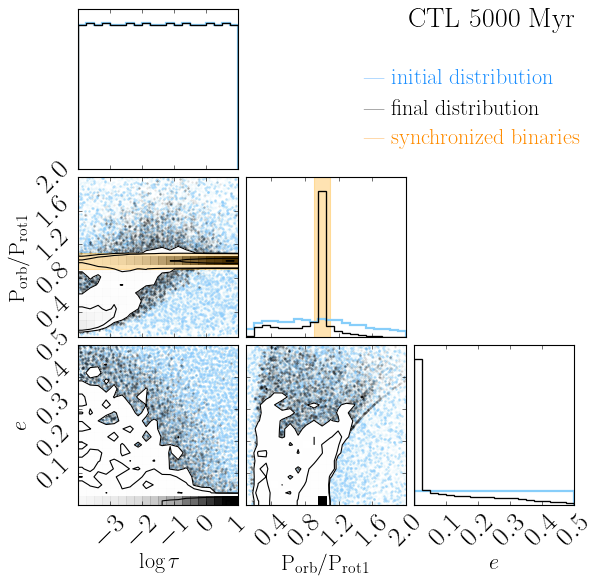

In [25]:
rng = ctl_synth.inparams_var.dict_bounds
plot_bounds = [rng['primary.dTidalTau'],
               (.1,2),
               rng['secondary.dEcc'],
            #    rng['primary.dRotPeriod'],
            #    rng['secondary.dRotPeriod']
               ]
labels = [r"$\log\tau$", r"$\rm P_{orb}/P_{rot1}$",  r"$e$"]#, "Prot1", "Prot2"]

plot_vars_prior = np.array([ctl_results["primary.dTidalTau"],
                            ctl_results["secondary.dOrbPeriod"] /
                            ctl_results["primary.dRotPeriod"],
                            ctl_results["secondary.dEcc"],
                            # ctl_results["primary.dRotPeriod"],
                            # ctl_results["secondary.dRotPeriod"]
                            ]).T

plot_vars = np.array([ctl_results["primary.dTidalTau"],
                      ctl_results["porb_prot1"],
                      ctl_results["final.secondary.Eccentricity"],
                    #   ctl_results["final.primary.RotPer"],
                    #   ctl_results["final.secondary.RotPer"]
                      ]).T

fig = corner.corner(plot_vars_prior,
              labels=labels,
              range=plot_bounds,
              label_kwargs={"fontsize": 20}, 
              color="lightskyblue",
              plot_datapoints=True, plot_density=False, plot_contours=False, 
              hist_kwargs={"density": True, "linewidth": 2})

corner.corner(plot_vars,
              labels=labels,
              range=plot_bounds,
              label_kwargs={"fontsize": 20},
              color="k",
              hist_kwargs={"density": True, "linewidth": 1.2},
              fig=fig);

# highlight synchronized binaries
ndim = len(plot_bounds)
axes = np.array(fig.axes).reshape((ndim, ndim))
axes[1, 0].axhspan(0.9, 1.1, color="orange", alpha=0.3)
axes[1, 1].axvspan(0.9, 1.1, color="orange", alpha=0.3)

plt.text(0.95, 0.95, f"CTL {int(ages[idx])} Myr", fontsize=25, transform=fig.transFigure,
         verticalalignment='top', horizontalalignment='right')
plt.text(0.6, 0.85, f"--- initial distribution", fontsize=20, transform=fig.transFigure,
         verticalalignment='top', horizontalalignment='left', color="dodgerblue")
plt.text(0.6, 0.8, f"--- final distribution", fontsize=20, transform=fig.transFigure,
         verticalalignment='top', horizontalalignment='left')
plt.text(0.6, 0.75, f"--- synchronized binaries", fontsize=20, transform=fig.transFigure,
         verticalalignment='top', horizontalalignment='left', color="darkorange")


plt.savefig(f"../apj_submission2/corner_ctl_porb_prot.png", bbox_inches="tight", dpi=300)

In [18]:
idx = 5
cpl_results = dict(
    zip(cpl_synth.inparams_var.names, cpl_initial_states[idx].T))
# cpl_results.update(dict(zip(cpl_synth.outparams.names, Y.T)))
cpl_results['final.primary.RotPer'] = cpl_final_states[idx].T[0]
cpl_results['final.secondary.Eccentricity'] = cpl_final_states[idx].T[1]
cpl_results['final.secondary.OrbPeriod'] = cpl_final_states[idx].T[2]
cpl_results['final.secondary.RotPer'] = cpl_final_states[idx].T[3]
cpl_results["porb_prot1"] = cpl_results['final.secondary.OrbPeriod'] / \
    cpl_results['final.primary.RotPer']
cpl_results["porb_prot2"] = cpl_results['final.secondary.OrbPeriod'] / \
    cpl_results['final.secondary.RotPer']

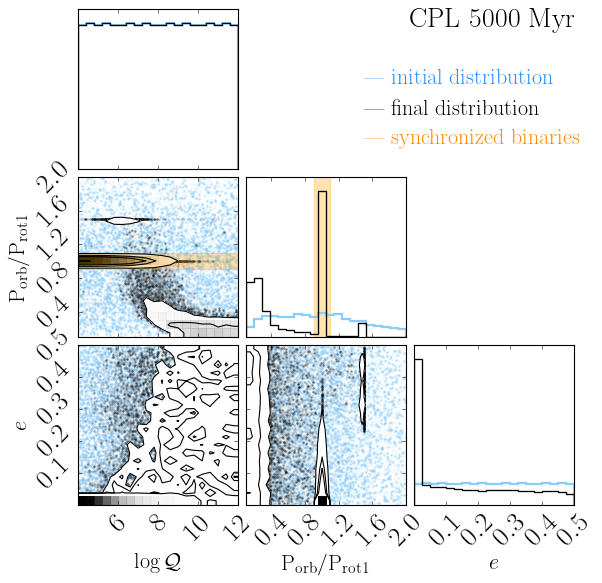

In [24]:
rng = cpl_synth.inparams_var.dict_bounds
plot_bounds = [rng['primary.dTidalQ'],
               (.1, 2),
               rng['secondary.dEcc'],
            #    rng['primary.dRotPeriod'],
            #    rng['secondary.dRotPeriod']
               ]
labels = [r"$\log\mathcal{Q}$", r"$\rm P_{orb}/P_{rot1}$", r"$e$"]#, "Prot1", "Prot2"]

plot_vars_prior = np.array([cpl_results["primary.dTidalQ"],
                            cpl_results["secondary.dOrbPeriod"] / cpl_results["primary.dRotPeriod"],
                            cpl_results["secondary.dEcc"],
                            # cpl_results["primary.dRotPeriod"],
                            # cpl_results["secondary.dRotPeriod"]
                            ]).T

plot_vars = np.array([cpl_results["primary.dTidalQ"],
                      cpl_results["porb_prot1"],
                      cpl_results["final.secondary.Eccentricity"],
                    #   cpl_results["final.primary.RotPer"],
                    #   cpl_results["final.secondary.RotPer"]
                      ]).T

fig = corner.corner(plot_vars_prior,
                    labels=labels,
                    range=plot_bounds,
                    label_kwargs={"fontsize": 20},
                    color="lightskyblue",
                    plot_datapoints=True, plot_density=False, plot_contours=False,
                    hist_kwargs={"density": True, "linewidth": 2})

corner.corner(plot_vars,
              labels=labels,
              range=plot_bounds,
              label_kwargs={"fontsize": 20},
              color="k",
              hist_kwargs={"density": True, "linewidth": 1.2},
              fig=fig);

# highlight synchronized binaries 
ndim = len(plot_bounds)
axes = np.array(fig.axes).reshape((ndim, ndim))
axes[1,0].axhspan(0.9, 1.1, color="orange", alpha=0.3)
axes[1, 1].axvspan(0.9, 1.1, color="orange", alpha=0.3)

plt.text(0.95, 0.95, f"CPL {int(ages[idx])} Myr", fontsize=25, transform=fig.transFigure,
         verticalalignment='top', horizontalalignment='right')
plt.text(0.6, 0.85, f"--- initial distribution", fontsize=20, transform=fig.transFigure,
         verticalalignment='top', horizontalalignment='left', color="dodgerblue")
plt.text(0.6, 0.8, f"--- final distribution", fontsize=20, transform=fig.transFigure,
         verticalalignment='top', horizontalalignment='left')
plt.text(0.6, 0.75, f"--- synchronized binaries", fontsize=20, transform=fig.transFigure,
         verticalalignment='top', horizontalalignment='left', color="darkorange")

plt.savefig(f"../apj_submission2/corner_cpl_porb_prot.png", bbox_inches="tight", dpi=300)

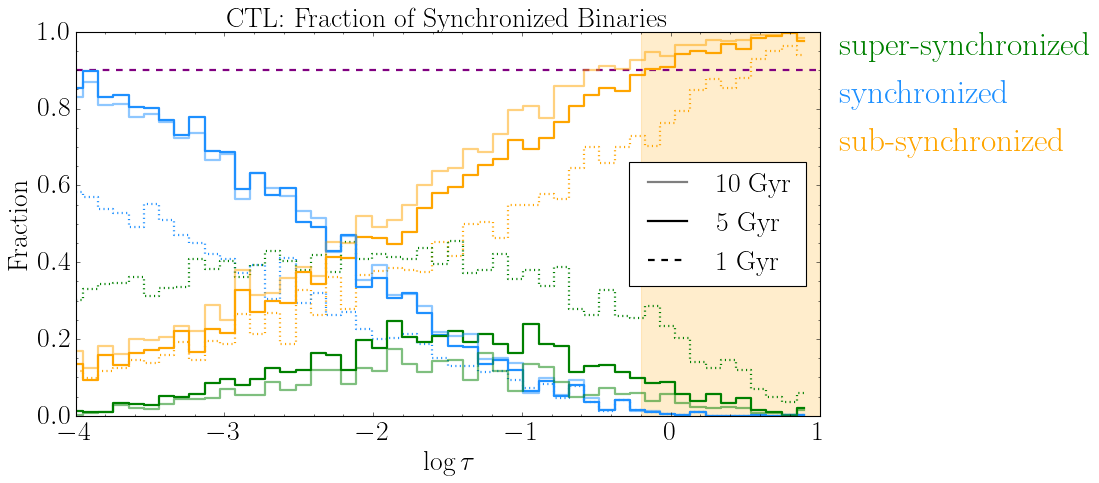

In [27]:


plt.figure(figsize=(12, 6))
plt.axhline(.9, color="purple", linestyle="dashed", linewidth=2)
plt.axvspan(-0.2, 1, color="orange", alpha=0.2)
# plt.axvspan(-3,-4, color="dodgerblue", alpha=0.2)

for jj, idx in enumerate([4, 5, 6]):
    
    ctl_results = dict(
        zip(ctl_synth.inparams_var.names, ctl_initial_states[idx].T))
    ctl_results['final.primary.RotPer'] = ctl_final_states[idx].T[0]
    ctl_results['final.secondary.Eccentricity'] = ctl_final_states[idx].T[1]
    ctl_results['final.secondary.OrbPeriod'] = ctl_final_states[idx].T[2]
    ctl_results['final.secondary.RotPer'] = ctl_final_states[idx].T[3]
    ctl_results["porb_prot1"] = ctl_results['final.secondary.OrbPeriod'] / \
        ctl_results['final.primary.RotPer']
        
    sync = (ctl_results["porb_prot1"] < 1.05) & (ctl_results["porb_prot1"] > 0.95)
    subsync = (ctl_results["porb_prot1"] < .95)
    supsync = (ctl_results["porb_prot1"] > 1.05)
    
    tdist = ctl_results["primary.dTidalTau"]

    bins = np.linspace(-4, 1, 50)
    fracs = []
    for ii in range(len(bins)-1):
        bin_sync = tdist[sync][(tdist[sync] > bins[ii]) & (tdist[sync] < bins[ii+1])]
        bin_subsync = tdist[subsync][(tdist[subsync] > bins[ii]) & (tdist[subsync] < bins[ii+1])]
        bin_supsync = tdist[supsync][(tdist[supsync] > bins[ii]) & (tdist[supsync] < bins[ii+1])]
        bin_total = len(bin_sync) + len(bin_subsync) + len(bin_supsync)
        fracs.append([len(bin_sync) / bin_total, len(bin_subsync) / bin_total, len(bin_supsync) / bin_total])
        
    # -------------------------------------------------

    labels = ["Synchronized", "Sub-synchronized", "Super-synchronized"]
    colors = ["orange", "dodgerblue", "green"]

    for ii, ff in enumerate(np.array(fracs).T):
        if jj == 0:
            plt.step(bins[:-1], ff, where='mid', linewidth=2,
                     color=colors[ii], linestyle="dotted")
        elif jj == 1:
            # plt.step(bins[:-1], ff, where='mid', linewidth=2,
            #          label=labels[ii], color=colors[ii], linestyle="solid")
            plt.step(bins[:-1], ff, where='mid', linewidth=2, color=colors[ii], linestyle="solid")
        elif jj == 2:
            plt.step(bins[:-1], ff, where='mid', linewidth=2,
                     color=colors[ii], alpha=0.5)
            
plt.text(0.92, 0.9, f"super-synchronized", fontsize=30, transform=plt.gcf().transFigure, color=colors[2],
         verticalalignment='top', horizontalalignment='left')
plt.text(0.92, 0.8, f"synchronized", fontsize=30, transform=plt.gcf().transFigure, color=colors[1],
         verticalalignment='top', horizontalalignment='left')
plt.text(0.92, 0.7, f"sub-synchronized", fontsize=30, transform=plt.gcf().transFigure, color=colors[0],
         verticalalignment='top', horizontalalignment='left')

plt.axhline(2, color="k", label="10 Gyr", linewidth=2, alpha=0.5)
plt.axhline(2, color="k", label="5 Gyr", linewidth=2)
plt.axhline(2, color="k", label="1 Gyr", linewidth=2, linestyle="dashed")
plt.legend(loc="center right", fontsize=25)

plt.xlabel(r"$\log\tau$", fontsize=25)
plt.ylabel("Fraction", fontsize=25)
plt.title("CTL: Fraction of Synchronized Binaries", fontsize=25)
# plt.gca().invert_xaxis()
plt.xlim(-4, 1)
plt.ylim(0,1)
plt.minorticks_on()
plt.savefig(f"../apj_submission2/ctl_sync_frac.png", bbox_inches="tight", dpi=500)
plt.show()

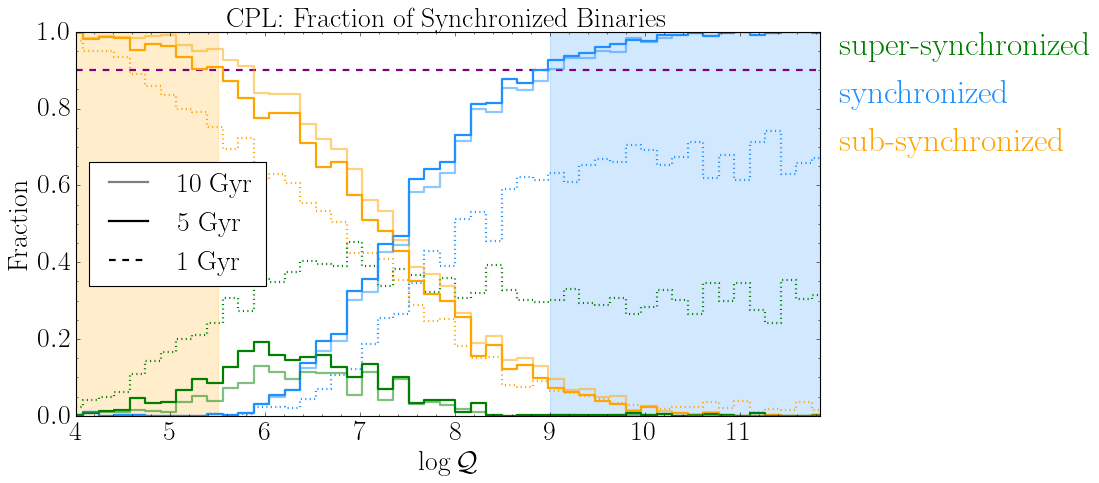

In [28]:

styles = ["dashed", "solid", "dotted"]

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
plt.axhline(.9, color="purple", linestyle="dashed", linewidth=2)
plt.axvspan(4, 5.5, color="orange", alpha=0.2)
plt.axvspan(9, 12, color="dodgerblue", alpha=0.2)

for jj, idx in enumerate([4, 5, 6]):

    cpl_results = dict(
        zip(cpl_synth.inparams_var.names, cpl_initial_states[idx].T))
    cpl_results['final.primary.RotPer'] = cpl_final_states[idx].T[0]
    cpl_results['final.secondary.Eccentricity'] = cpl_final_states[idx].T[1]
    cpl_results['final.secondary.OrbPeriod'] = cpl_final_states[idx].T[2]
    cpl_results['final.secondary.RotPer'] = cpl_final_states[idx].T[3]
    cpl_results["porb_prot1"] = cpl_results['final.secondary.OrbPeriod'] / \
        cpl_results['final.primary.RotPer']
    cpl_results["porb_prot2"] = cpl_results['final.secondary.OrbPeriod'] / \
        cpl_results['final.secondary.RotPer']

    qdist = cpl_results["primary.dTidalQ"]

    sync = (cpl_results["porb_prot1"] < 1.05) & (cpl_results["porb_prot1"] > 0.95)
    subsync = (cpl_results["porb_prot1"] < .95)
    supsync = (cpl_results["porb_prot1"] > 1.05)

    bins = np.linspace(4, 12, 50)
    fracs = []
    for ii in range(len(bins)-1):
        bin_sync = qdist[sync][(qdist[sync] > bins[ii]) & (qdist[sync] < bins[ii+1])]
        bin_subsync = qdist[subsync][(qdist[subsync] > bins[ii]) & (qdist[subsync] < bins[ii+1])]
        bin_supsync = qdist[supsync][(qdist[supsync] > bins[ii]) & (qdist[supsync] < bins[ii+1])]
        bin_total = len(bin_sync) + len(bin_subsync) + len(bin_supsync)
        fracs.append([len(bin_sync) / bin_total, len(bin_subsync) / bin_total, len(bin_supsync) / bin_total])
        
    # -------------------------------------------------
    labels = ["Synchronized", "Sub-synchronized", "Super-synchronized"]
    colors = ["orange", "dodgerblue", "green"]
    
    for ii, ff in enumerate(np.array(fracs).T):
        if jj == 0:
            axes.step(bins[:-1], ff, where='mid', linewidth=2, color=colors[ii], linestyle="dotted")
        elif jj == 1:
            # axes.step(bins[:-1], ff, where='mid', linewidth=2, label=labels[ii], color=colors[ii], linestyle="solid")
            axes.step(bins[:-1], ff, where='mid', linewidth=2, color=colors[ii], linestyle="solid")
        elif jj == 2:
            axes.step(bins[:-1], ff, where='mid', linewidth=2, color=colors[ii], alpha=0.5)

plt.text(0.92, 0.9, f"super-synchronized", fontsize=30, transform=plt.gcf().transFigure, color=colors[2],
         verticalalignment='top', horizontalalignment='left')
plt.text(0.92, 0.8, f"synchronized", fontsize=30, transform=plt.gcf().transFigure, color=colors[1],
         verticalalignment='top', horizontalalignment='left')
plt.text(0.92, 0.7, f"sub-synchronized", fontsize=30, transform=plt.gcf().transFigure, color=colors[0],
         verticalalignment='top', horizontalalignment='left')

axes.axhline(2, color="k", label="10 Gyr", linewidth=2, alpha=0.5)
axes.axhline(2, color="k", label="5 Gyr", linewidth=2)
axes.axhline(2, color="k", label="1 Gyr", linewidth=2, linestyle="dashed")
plt.legend(loc="center left", fontsize=25)

plt.xlabel(r"$\log\mathcal{Q}$", fontsize=25)
plt.ylabel("Fraction", fontsize=25)
plt.xlim(bins[0], bins[-2])
plt.ylim(0,1)
plt.title("CPL: Fraction of Synchronized Binaries", fontsize=25)
plt.minorticks_on()
plt.savefig(f"../apj_submission2/cpl_sync_frac.png", bbox_inches="tight", dpi=500)
plt.show()

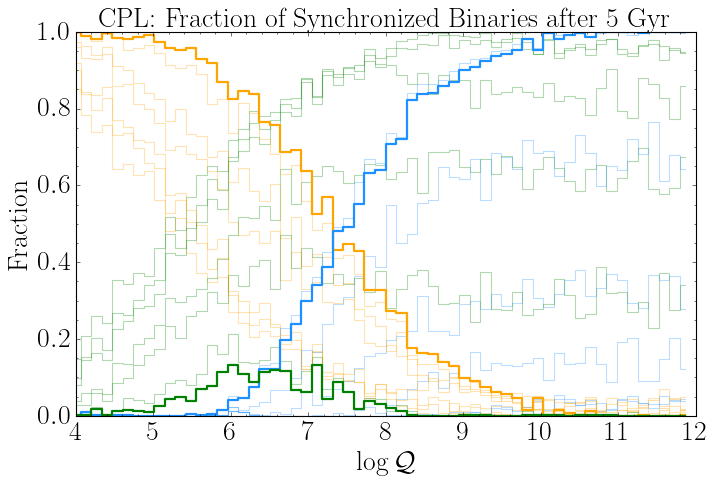

In [ ]:
bins = np.linspace(4, 12, 60)
styles = ["dashed", "solid", "dotted"]

plt.figure(figsize=(10, 6))
for jj, idx in enumerate(range(7)):

    cpl_results = dict(
        zip(cpl_synth.inparams_var.names, cpl_initial_states[idx].T))
    cpl_results['final.primary.RotPer'] = cpl_final_states[idx].T[0]
    cpl_results['final.secondary.Eccentricity'] = cpl_final_states[idx].T[1]
    cpl_results['final.secondary.OrbPeriod'] = cpl_final_states[idx].T[2]
    cpl_results['final.secondary.RotPer'] = cpl_final_states[idx].T[3]
    cpl_results["porb_prot1"] = cpl_results['final.secondary.OrbPeriod'] / \
        cpl_results['final.primary.RotPer']
    cpl_results["porb_prot2"] = cpl_results['final.secondary.OrbPeriod'] / \
        cpl_results['final.secondary.RotPer']

    qdist = cpl_results["primary.dTidalQ"]

    sync = (cpl_results["porb_prot1"] < 1.05) & (
        cpl_results["porb_prot1"] > 0.95)
    subsync = (cpl_results["porb_prot1"] < .95)
    supsync = (cpl_results["porb_prot1"] > 1.05)

    fracs = []
    for ii in range(len(bins)-1):
        bin_sync = qdist[sync][(qdist[sync] > bins[ii])
                               & (qdist[sync] < bins[ii+1])]
        bin_subsync = qdist[subsync][(qdist[subsync] > bins[ii]) & (
            qdist[subsync] < bins[ii+1])]
        bin_supsync = qdist[supsync][(qdist[supsync] > bins[ii]) & (
            qdist[supsync] < bins[ii+1])]
        bin_total = len(bin_sync) + len(bin_subsync) + len(bin_supsync)
        fracs.append([len(bin_sync) / bin_total, len(bin_subsync) /
                     bin_total, len(bin_supsync) / bin_total])

    # -------------------------------------------------
    labels = ["Synchronized", "Sub-synchronized", "Super-synchronized"]
    colors = ["orange", "dodgerblue", "green"]

    # for ii, ff in enumerate(np.array(fracs).T):
    #     if jj == 6:
    #         plt.step(bins[:-1], ff, where='mid', linewidth=2, color=colors[ii], alpha=1)
    #     else:
    #         plt.step(bins[:-1], ff, where='mid', linewidth=1, color=colors[ii], alpha=0.3)
    
    

plt.xlabel(r"$\log\mathcal{Q}$", fontsize=25)
plt.ylabel("Fraction", fontsize=25)
# plt.legend(loc="best", fontsize=20)
plt.title("CPL: Fraction of Synchronized Binaries after 5 Gyr", fontsize=25)
plt.minorticks_on()
# plt.savefig(f"../apj_submission2/cpl_sync_frac.png", bbox_inches="tight", dpi=500)
plt.show()

In [ ]:
ctl = vpi.VplanetModel(ctl_synth.inparams_all.dict_units, 
                       inpath=os.path.join(vpi.INFILE_DIR, "stellar_eqtide/ctl"), 
                       outparams=ctl_synth.outparams.dict_units,
                       verbose=False, timesteps=1e6*u.yr, time_init=5e6*u.yr)

cpl = vpi.VplanetModel(cpl_synth.inparams_all.dict_units,
                       inpath=os.path.join(vpi.INFILE_DIR, "stellar_eqtide/cpl"),
                       outparams=ctl_synth.outparams.dict_units,
                       verbose=False, timesteps=1e6*u.yr, time_init=5e6*u.yr)


def run_models(vpm, theta_var_array, ncore=4):
    with mp.Pool(ncore) as p:
        outputs = []
        for result in tqdm.tqdm(p.imap(func=vpm.run_model, iterable=theta_var_array), total=len(theta_var_array)):
            outputs.append(result)
        outputs = np.array(outputs)
    return outputs

<>:5: SyntaxWarning: invalid escape sequence '\('
<>:5: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_132454/830633197.py:5: SyntaxWarning: invalid escape sequence '\('
  inlabels = [re.sub("[\(\[].*?[]\)\]]", "", lbl).split("]")[0] + " " for lbl in ctl_synth.inparams_var.labels]


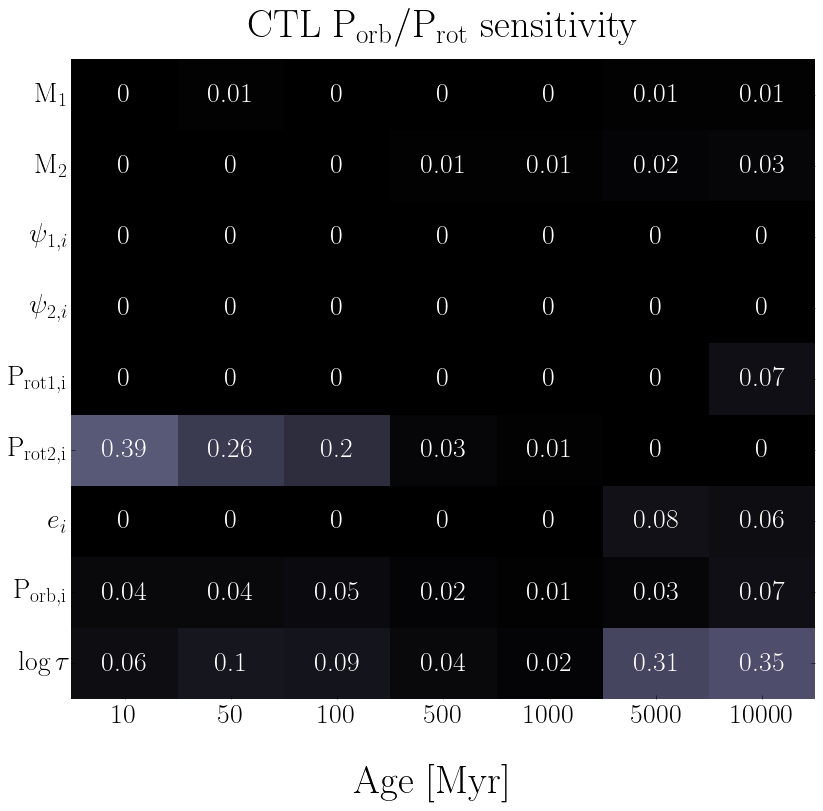

In [10]:
title_size=35
annot_size=25
label_size=22
cmap="bone"
inlabels = [re.sub("[\(\[].*?[]\)\]]", "", lbl).split("]")[0] + " " for lbl in ctl_synth.inparams_var.labels]

fig, axs = plt.subplots(1,1, figsize=[12,10])
plt.subplots_adjust(wspace=.01)

df = pd.DataFrame(data=ctl_tsort["porb_prot"])
sn.heatmap(df, yticklabels=inlabels, xticklabels=np.array(ages, dtype=int), annot=True,
           annot_kws={"size": annot_size}, cbar=False, ax=axs, vmin=0, vmax=1, cmap=cmap)
axs.set_title(r"CTL $\rm P_{orb}/P_{rot}$ sensitivity",fontsize=title_size, pad=20)

fig.supxlabel("Age [Myr]", fontsize=title_size, y=-.03)
# axs[0].set_ylabel(model.upper()[0:3] + "  initial conditions", fontsize=title_size)
axs.tick_params(labelrotation=0)

plt.savefig(f"../apj_submission2/sensitivity_ctl_porb_prot.png", bbox_inches="tight", dpi=300)
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\('
<>:5: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_132454/3244709663.py:5: SyntaxWarning: invalid escape sequence '\('
  inlabels = [re.sub("[\(\[].*?[]\)\]]", "", lbl) + " " for lbl in cpl_synth.inparams_var.labels]


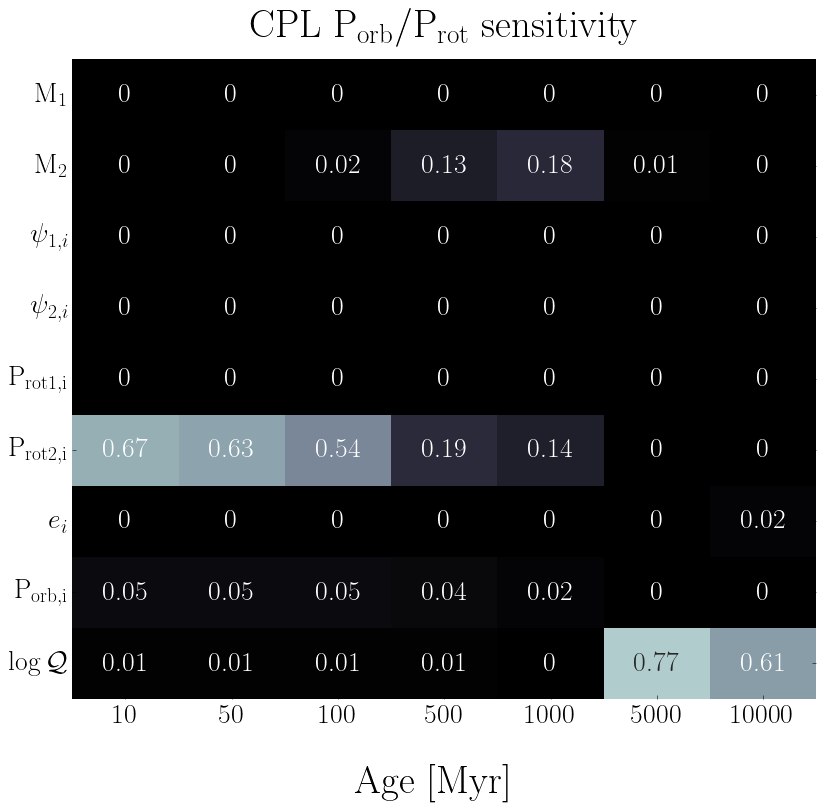

In [8]:
title_size = 35
annot_size = 25
label_size = 22
cmap = "bone"
inlabels = [re.sub("[\(\[].*?[]\)\]]", "", lbl) + " " for lbl in cpl_synth.inparams_var.labels]

fig, axs = plt.subplots(1, 1, figsize=[12, 10])
plt.subplots_adjust(wspace=.01)

df = pd.DataFrame(data=cpl_tsort["porb_prot"])
sn.heatmap(df, yticklabels=inlabels, xticklabels=np.array(ages, dtype=int), annot=True,
           annot_kws={"size": annot_size}, cbar=False, ax=axs, vmin=0, vmax=1, cmap=cmap)
axs.set_title(r"CPL $\rm P_{orb}/P_{rot}$ sensitivity", fontsize=title_size, pad=20)

fig.supxlabel("Age [Myr]", fontsize=title_size, y=-.03)
# axs[0].set_ylabel(model.upper()[0:3] + "  initial conditions", fontsize=title_size)
axs.tick_params(labelrotation=0)

plt.savefig(f"../apj_submission2/sensitivity_cpl_porb_prot.png", bbox_inches="tight", dpi=300)
plt.show()